# Seminar Project: Distance Mapping Using Doc2Vec Embedding and PCA
---------------
``` 

Jakob Amann
Elias Gabriel Heppner, 1244414
Andri Rutschmann

### Loading Packages


In [1]:
import numpy as np 
import pandas as pd 
import time
import pickle
import time
import os
import datetime
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

# probably wise to switch to tiktoken as tokenizer as this is the one recommended by OpenAI 
import nltk
nltk.download('punkt')  # Nur notwendig beim ersten Mal
from nltk.tokenize import word_tokenize # import tokenizer to estimate token count of a speech


c:\Users\elias\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\elias\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


### Load Speeches Data


In [2]:
#Define 
os.chdir("../data/opendiscourse")
os.getcwd()

'c:\\Users\\elias\\Documents\\Master\\3. Semester\\LLM\\Politricks\\data\\opendiscourse'

In [3]:
import zipfile
import csv
import io

zip_file_path = 'sub_speeches.zip'

# Name of the CSV file within the zip file
csv_file_name = 'sub_speeches.csv'

# Open the zip file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    # Read the CSV file directly into a Pandas DataFrame
    with zip_ref.open(csv_file_name) as file:
        speeches_df = pd.read_csv(file)


In [4]:
speeches_df = speeches_df.dropna(subset=['speech_content'])
speeches_df

id_x  session  electoral_term        date  \
0        810543       79              18  2015-01-15   
1        812133       86              18  2015-02-06   
2        812135       86              18  2015-02-06   
3        812137       86              18  2015-02-06   
4        812836       89              18  2015-02-27   
...         ...      ...             ...         ...   
109223  1068690       23              20  2022-03-22   
109224  1072715       37              20  2022-05-19   
109225  1069211       25              20  2022-03-24   
109226  1071552       34              20  2022-05-12   
109227  1071712       35              20  2022-05-13   

                                             document_url  \
0       https://dip21.bundestag.de/dip21/btp/18/18079.pdf   
1       https://dip21.bundestag.de/dip21/btp/18/18086.pdf   
2       https://dip21.bundestag.de/dip21/btp/18/18086.pdf   
3       https://dip21.bundestag.de/dip21/btp/18/18086.pdf   
4       https://dip21.bundestag.de/dip21/btp/18/18089.pdf   
...                                                   ...   
109223  https://dip21.bundestag.de/dip21/btp/20/20023.pdf   
109224  https://dip21.bundestag.de/dip21/btp/20/20037.pdf   
109225  https://dip21.bundestag.de/dip21/btp/20/20025.pdf   
109226  https://dip21.bundestag.de/dip21/btp/20/20034.pdf   
109227  https://dip21.bundestag.de/dip21/btp/20/20035.pdf   

                                           speech_content  politician_id  \
0       Frau Präsidentin! Meine Damen und Herren! Lieb...       11003801   
1       Frau Präsidentin! Meine lieben Kolleginnen und...       11003801   
2                                          Ja, bitte.\n\n       11003801   
3       Es ist gar keine Frage, dass es hier zu Übersc...       11003801   
4       Vielen Dank, Herr Präsident. - Liebe Kolleginn...       11003801   
...                                                   ...            ...   
109223  \n\nSehr geehrte Frau Präsidentin! Werte Kolle...       11005031   
109224  \n\nSehr geehrte Frau Präsidentin! Meine vereh...       11005031   
109225  \n\nSehr geehrter Herr Präsident! Sehr geehrte...       11005100   
109226  \n\nSehr geehrter Herr Präsident! Werte Kolleg...       11005156   
109227  \n\nFrau Präsidentin! Sehr geehrte Damen und H...       11005092   

       first_name last_name  faction_id abbreviation  \
0         Ingbert   Liebing           4      CDU/CSU   
1         Ingbert   Liebing           4      CDU/CSU   
2         Ingbert   Liebing           4      CDU/CSU   
3         Ingbert   Liebing           4      CDU/CSU   
4         Ingbert   Liebing           4      CDU/CSU   
...           ...       ...         ...          ...   
109223       Dirk   Brandes           0          AfD   
109224       Dirk   Brandes           0          AfD   
109225    Michael  Kaufmann           0          AfD   
109226       Mike   Moncsek           0          AfD   
109227    Steffen    Janich           0          AfD   

                                                full_name  
0       Christlich Demokratische Union Deutschlands/Ch...  
1       Christlich Demokratische Union Deutschlands/Ch...  
2       Christlich Demokratische Union Deutschlands/Ch...  
3       Christlich Demokratische Union Deutschlands/Ch...  
4       Christlich Demokratische Union Deutschlands/Ch...  
...                                                   ...  
109223                        Alternative für Deutschland  
109224                        Alternative für Deutschland  
109225                        Alternative für Deutschland  
109226                        Alternative für Deutschland  
109227                        Alternative für Deutschland  

[109201 rows x 12 columns]

In [5]:
from collections import Counter
from nltk.tokenize import word_tokenize
# Function to tokenize a string
def tokenize_string(text):
    tokens = word_tokenize(text.lower())  # Convert to lowercase and tokenize
    return tokens

# Tokenize the strings in the DataFrame column
speeches_df['tokens'] = speeches_df['speech_content'].apply(tokenize_string)

# Flatten the list of tokens
all_tokens = [token for sublist in speeches_df['tokens'] for token in sublist]

# Count the frequency of each token
token_counts = Counter(all_tokens)

# Get the most common tokens and their frequencies
most_common_tokens = token_counts.most_common()

print("Most frequent tokens:")
for token, count in most_common_tokens:
    print(f"{token}: {count}")

Most frequent tokens:
,: 1834662
.: 1509088
die: 911584
und: 723599
der: 688788
das: 495130
wir: 467555
in: 442602
ist: 379447
): 337550
(: 334862
{: 333706
}: 333706
sie: 307780
es: 302219
nicht: 281430
auch: 272439
den: 272111
zu: 269682
ich: 264651
dass: 259770
für: 246329
von: 194766
:: 194651
haben: 193944
mit: 183505
eine: 175669
–: 169486
im: 167833
ein: 160270
auf: 159744
sind: 135559
werden: 133546
aber: 124553
sich: 122777
hat: 121946
des: 111838
dem: 110162
an: 104250
!: 101948
-: 98760
als: 96448
wie: 95560
wenn: 92553
noch: 90488
bei: 90058
uns: 89930
wird: 88839
um: 87737
man: 79802
so: 79442
hier: 78178
?: 77569
0: 75463
sehr: 74761
;: 74197
nur: 73815
diese: 73484
was: 72170
einen: 70897
müssen: 70625
aus: 69720
dann: 68609
können: 65861
über: 65480
vor: 64500
zum: 63185
mehr: 62454
jetzt: 62279
kann: 61371
herr: 60568
dieser: 60535
muss: 57383
oder: 56358
menschen: 55171
kollegen: 54552
zur: 54306
meine: 54174
einer: 54078
wollen: 52919
schon: 50253
nach: 49667
da: 486

In [6]:
most_common_tokens = token_counts.most_common(n=-1)

print("Most frequent tokens:")
for token, count in most_common_tokens:
    print(f"{token}: {count}")

Most frequent tokens:


In [29]:
keywords = ['corona', 'covid']

# Filter the DataFrame
filtered_df = speeches_df[speeches_df['speech_content'].str.lower().str.contains('|'.join(keywords))]
filtered_df.reset_index(drop=True, inplace=True)
filtered_df = filtered_df.sample(n=40, random_state=42)  # You can adjust the random_state for reproducibility
filtered_df.reset_index(drop=True, inplace=True)
filtered_df

id_x  session  electoral_term        date  \
0   1053795      206              19  2021-01-28   
1   1050697      194              19  2020-11-25   
2   1052566      202              19  2020-12-17   
3   1046545      180              19  2020-10-01   
4   1041775      164              19  2020-05-29   
5   1059553      224              19  2021-04-22   
6   1065992       13              20  2022-01-26   
7   1052871      203              19  2021-01-13   
8   1042223      165              19  2020-06-17   
9   1043179      169              19  2020-07-01   
10  1049193      189              19  2020-11-05   
11  1048928      189              19  2020-11-05   
12  1047238      183              19  2020-10-08   
13  1047455      183              19  2020-10-08   
14  1040166      159              19  2020-05-13   
15  1053650      205              19  2021-01-27   
16  1042873      167              19  2020-06-19   
17  1048560      187              19  2020-10-30   
18  1042867      167              19  2020-06-19   
19  1043365      170              19  2020-07-02   
20  1067502       20              20  2022-03-16   
21  1058928      223              19  2021-04-21   
22  1067646       20              20  2022-03-16   
23  1063302      236              19  2021-06-24   
24  1066516       15              20  2022-04-07   
25  1044861      174              19  2020-09-11   
26  1041132      162              19  2020-05-27   
27  1041877      164              19  2020-05-29   
28  1041042      161              19  2020-05-15   
29  1065577       12              20  2022-01-14   
30  1059885      225              19  2021-04-23   
31  1058056      220              19  2021-04-13   
32  1059793      225              19  2021-04-23   
33  1054627      209              19  2021-02-11   
34  1055233      210              19  2021-02-12   
35  1051918      199              19  2020-12-10   
36  1042337      166              19  2020-06-18   
37  1045663      176              19  2020-09-17   
38  1069296       26              20  2022-03-25   
39  1046297      179              19  2020-09-30   

                                         document_url  \
0   https://dip21.bundestag.de/dip21/btp/19/19206.pdf   
1   https://dip21.bundestag.de/dip21/btp/19/19194.pdf   
2   https://dip21.bundestag.de/dip21/btp/19/19202.pdf   
3   https://dip21.bundestag.de/dip21/btp/19/19180.pdf   
4   https://dip21.bundestag.de/dip21/btp/19/19164.pdf   
5   https://dip21.bundestag.de/dip21/btp/19/19224.pdf   
6   https://dip21.bundestag.de/dip21/btp/20/20013.pdf   
7   https://dip21.bundestag.de/dip21/btp/19/19203.pdf   
8   https://dip21.bundestag.de/dip21/btp/19/19165.pdf   
9   https://dip21.bundestag.de/dip21/btp/19/19169.pdf   
10  https://dip21.bundestag.de/dip21/btp/19/19189.pdf   
11  https://dip21.bundestag.de/dip21/btp/19/19189.pdf   
12  https://dip21.bundestag.de/dip21/btp/19/19183.pdf   
13  https://dip21.bundestag.de/dip21/btp/19/19183.pdf   
14  https://dip21.bundestag.de/dip21/btp/19/19159.pdf   
15  https://dip21.bundestag.de/dip21/btp/19/19205.pdf   
16  https://dip21.bundestag.de/dip21/btp/19/19167.pdf   
17  https://dip21.bundestag.de/dip21/btp/19/19187.pdf   
18  https://dip21.bundestag.de/dip21/btp/19/19167.pdf   
19  https://dip21.bundestag.de/dip21/btp/19/19170.pdf   
20  https://dip21.bundestag.de/dip21/btp/20/20020.pdf   
21  https://dip21.bundestag.de/dip21/btp/19/19223.pdf   
22  https://dip21.bundestag.de/dip21/btp/20/20020.pdf   
23  https://dip21.bundestag.de/dip21/btp/19/19236.pdf   
24  https://dip21.bundestag.de/dip21/btp/20/20015.pdf   
25  https://dip21.bundestag.de/dip21/btp/19/19174.pdf   
26  https://dip21.bundestag.de/dip21/btp/19/19162.pdf   
27  https://dip21.bundestag.de/dip21/btp/19/19164.pdf   
28  https://dip21.bundestag.de/dip21/btp/19/19161.pdf   
29  https://dip21.bundestag.de/dip21/btp/20/20012.pdf   
30  https://dip21.bundestag.de/dip21/btp/19/19225.pdf   
31  https://dip21.bundestag.de/dip21/btp/19/19220.

In [103]:
filtered_df["pol_name"] = filtered_df["first_name"] + '_' + filtered_df["last_name"]
filtered_df

id_x  session  electoral_term        date  \
0   1053795      206              19  2021-01-28   
1   1050697      194              19  2020-11-25   
2   1052566      202              19  2020-12-17   
3   1046545      180              19  2020-10-01   
4   1041775      164              19  2020-05-29   
5   1059553      224              19  2021-04-22   
6   1065992       13              20  2022-01-26   
7   1052871      203              19  2021-01-13   
8   1042223      165              19  2020-06-17   
9   1043179      169              19  2020-07-01   
10  1049193      189              19  2020-11-05   
11  1048928      189              19  2020-11-05   
12  1047238      183              19  2020-10-08   
13  1047455      183              19  2020-10-08   
14  1040166      159              19  2020-05-13   
15  1053650      205              19  2021-01-27   
16  1042873      167              19  2020-06-19   
17  1048560      187              19  2020-10-30   
18  1042867      167              19  2020-06-19   
19  1043365      170              19  2020-07-02   
20  1067502       20              20  2022-03-16   
21  1058928      223              19  2021-04-21   
22  1067646       20              20  2022-03-16   
23  1063302      236              19  2021-06-24   
24  1066516       15              20  2022-04-07   
25  1044861      174              19  2020-09-11   
26  1041132      162              19  2020-05-27   
27  1041877      164              19  2020-05-29   
28  1041042      161              19  2020-05-15   
29  1065577       12              20  2022-01-14   
30  1059885      225              19  2021-04-23   
31  1058056      220              19  2021-04-13   
32  1059793      225              19  2021-04-23   
33  1054627      209              19  2021-02-11   
34  1055233      210              19  2021-02-12   
35  1051918      199              19  2020-12-10   
36  1042337      166              19  2020-06-18   
37  1045663      176              19  2020-09-17   
38  1069296       26              20  2022-03-25   
39  1046297      179              19  2020-09-30   

                                         document_url  \
0   https://dip21.bundestag.de/dip21/btp/19/19206.pdf   
1   https://dip21.bundestag.de/dip21/btp/19/19194.pdf   
2   https://dip21.bundestag.de/dip21/btp/19/19202.pdf   
3   https://dip21.bundestag.de/dip21/btp/19/19180.pdf   
4   https://dip21.bundestag.de/dip21/btp/19/19164.pdf   
5   https://dip21.bundestag.de/dip21/btp/19/19224.pdf   
6   https://dip21.bundestag.de/dip21/btp/20/20013.pdf   
7   https://dip21.bundestag.de/dip21/btp/19/19203.pdf   
8   https://dip21.bundestag.de/dip21/btp/19/19165.pdf   
9   https://dip21.bundestag.de/dip21/btp/19/19169.pdf   
10  https://dip21.bundestag.de/dip21/btp/19/19189.pdf   
11  https://dip21.bundestag.de/dip21/btp/19/19189.pdf   
12  https://dip21.bundestag.de/dip21/btp/19/19183.pdf   
13  https://dip21.bundestag.de/dip21/btp/19/19183.pdf   
14  https://dip21.bundestag.de/dip21/btp/19/19159.pdf   
15  https://dip21.bundestag.de/dip21/btp/19/19205.pdf   
16  https://dip21.bundestag.de/dip21/btp/19/19167.pdf   
17  https://dip21.bundestag.de/dip21/btp/19/19187.pdf   
18  https://dip21.bundestag.de/dip21/btp/19/19167.pdf   
19  https://dip21.bundestag.de/dip21/btp/19/19170.pdf   
20  https://dip21.bundestag.de/dip21/btp/20/20020.pdf   
21  https://dip21.bundestag.de/dip21/btp/19/19223.pdf   
22  https://dip21.bundestag.de/dip21/btp/20/20020.pdf   
23  https://dip21.bundestag.de/dip21/btp/19/19236.pdf   
24  https://dip21.bundestag.de/dip21/btp/20/20015.pdf   
25  https://dip21.bundestag.de/dip21/btp/19/19174.pdf   
26  https://dip21.bundestag.de/dip21/btp/19/19162.pdf   
27  https://dip21.bundestag.de/dip21/btp/19/19164.pdf   
28  https://dip21.bundestag.de/dip21/btp/19/19161.pdf   
29  https://dip21.bundestag.de/dip21/btp/20/20012.pdf   
30  https://dip21.bundestag.de/dip21/btp/19/19225.pdf   
31  https://dip21.bundestag.de/dip21/btp/19/19220.

# Doc2Vec Encoding

In [118]:
inp_lst = filtered_df['speech_content'].tolist()

import gensim
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from gensim.models.phrases import Phrases, Phraser
import string
import nltk

# Download NLTK resources (if not already downloaded)
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Define preprocessing function
def preprocess_speech(text, bigram=None, trigram=None):
    # Tokenization
    tokens = word_tokenize(text, language="german")
    
    # Lowercasing
    tokens = [token.lower() for token in tokens]
    
    # Removing punctuation
    tokens = [token for token in tokens if token not in string.punctuation]
    
    # Removing stopwords
    stop_words = set(stopwords.words('german'))
    tokens = [token for token in tokens if token not in stop_words]
    tokens = [token for token in tokens if token not in parl_words]

    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    
    # Apply bigram phrase model if available
    if bigram:
        tokens = bigram[tokens]
    
    # Apply trigram phrase model if available
    if trigram:
        tokens = trigram[tokens]

    return tokens

# Define parliamentary words
parl_words = ["kolleginnen", "kollegen", "damen", "herren", "kollege", "kollegin", "präsident", "präsidentin"]

# Create bigram and trigram phrase models
bigram_phrases = Phrases(inp_lst, min_count=1)
bigram = Phraser(bigram_phrases)
trigram_phrases = Phrases(bigram[inp_lst], min_count=1)
trigram = Phraser(trigram_phrases)

# Preprocess each document
filtered_df["tokenized"] = [preprocess_speech(doc, bigram=bigram, trigram=trigram) for doc in inp_lst]

# Print preprocessed documents (for demonstration)
filtered_df
# # Tag documents
# tagged_documents = [TaggedDocument(words=doc, tags=[str(i)]) for i, doc in enumerate(preprocessed_documents)]
# preprocessed_documents
# # Train the model
# model = Doc2Vec(vector_size=200, window=20, min_count=1, workers=8, epochs=5)
# model.build_vocab(tagged_documents)
# model.train(tagged_documents, total_examples=model.corpus_count, epochs=model.epochs)

# Now the model is trained and ready to be used
# You can use model.infer_vector() to infer vectors for new documents


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\elias\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\elias\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\elias\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


id_x  session  electoral_term        date  \
0   1053795      206              19  2021-01-28   
1   1050697      194              19  2020-11-25   
2   1052566      202              19  2020-12-17   
3   1046545      180              19  2020-10-01   
4   1041775      164              19  2020-05-29   
5   1059553      224              19  2021-04-22   
6   1065992       13              20  2022-01-26   
7   1052871      203              19  2021-01-13   
8   1042223      165              19  2020-06-17   
9   1043179      169              19  2020-07-01   
10  1049193      189              19  2020-11-05   
11  1048928      189              19  2020-11-05   
12  1047238      183              19  2020-10-08   
13  1047455      183              19  2020-10-08   
14  1040166      159              19  2020-05-13   
15  1053650      205              19  2021-01-27   
16  1042873      167              19  2020-06-19   
17  1048560      187              19  2020-10-30   
18  1042867      167              19  2020-06-19   
19  1043365      170              19  2020-07-02   
20  1067502       20              20  2022-03-16   
21  1058928      223              19  2021-04-21   
22  1067646       20              20  2022-03-16   
23  1063302      236              19  2021-06-24   
24  1066516       15              20  2022-04-07   
25  1044861      174              19  2020-09-11   
26  1041132      162              19  2020-05-27   
27  1041877      164              19  2020-05-29   
28  1041042      161              19  2020-05-15   
29  1065577       12              20  2022-01-14   
30  1059885      225              19  2021-04-23   
31  1058056      220              19  2021-04-13   
32  1059793      225              19  2021-04-23   
33  1054627      209              19  2021-02-11   
34  1055233      210              19  2021-02-12   
35  1051918      199              19  2020-12-10   
36  1042337      166              19  2020-06-18   
37  1045663      176              19  2020-09-17   
38  1069296       26              20  2022-03-25   
39  1046297      179              19  2020-09-30   

                                         document_url  \
0   https://dip21.bundestag.de/dip21/btp/19/19206.pdf   
1   https://dip21.bundestag.de/dip21/btp/19/19194.pdf   
2   https://dip21.bundestag.de/dip21/btp/19/19202.pdf   
3   https://dip21.bundestag.de/dip21/btp/19/19180.pdf   
4   https://dip21.bundestag.de/dip21/btp/19/19164.pdf   
5   https://dip21.bundestag.de/dip21/btp/19/19224.pdf   
6   https://dip21.bundestag.de/dip21/btp/20/20013.pdf   
7   https://dip21.bundestag.de/dip21/btp/19/19203.pdf   
8   https://dip21.bundestag.de/dip21/btp/19/19165.pdf   
9   https://dip21.bundestag.de/dip21/btp/19/19169.pdf   
10  https://dip21.bundestag.de/dip21/btp/19/19189.pdf   
11  https://dip21.bundestag.de/dip21/btp/19/19189.pdf   
12  https://dip21.bundestag.de/dip21/btp/19/19183.pdf   
13  https://dip21.bundestag.de/dip21/btp/19/19183.pdf   
14  https://dip21.bundestag.de/dip21/btp/19/19159.pdf   
15  https://dip21.bundestag.de/dip21/btp/19/19205.pdf   
16  https://dip21.bundestag.de/dip21/btp/19/19167.pdf   
17  https://dip21.bundestag.de/dip21/btp/19/19187.pdf   
18  https://dip21.bundestag.de/dip21/btp/19/19167.pdf   
19  https://dip21.bundestag.de/dip21/btp/19/19170.pdf   
20  https://dip21.bundestag.de/dip21/btp/20/20020.pdf   
21  https://dip21.bundestag.de/dip21/btp/19/19223.pdf   
22  https://dip21.bundestag.de/dip21/btp/20/20020.pdf   
23  https://dip21.bundestag.de/dip21/btp/19/19236.pdf   
24  https://dip21.bundestag.de/dip21/btp/20/20015.pdf   
25  https://dip21.bundestag.de/dip21/btp/19/19174.pdf   
26  https://dip21.bundestag.de/dip21/btp/19/19162.pdf   
27  https://dip21.bundestag.de/dip21/btp/19/19164.pdf   
28  https://dip21.bundestag.de/dip21/btp/19/19161.pdf   
29  https://dip21.bundestag.de/dip21/btp/20/20012.pdf   
30  https://dip21.bundestag.de/dip21/btp/19/19225.pdf   
31  https://dip21.bundestag.de/dip21/btp/19/19220.

In [124]:
import pandas as pd
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

class DataFrameIterator(object):
    def __init__(self, dataframe, party_column=None, name_column=None):
        self.dataframe = dataframe
        self.party_column = party_column
        self.name_column = name_column

    def __iter__(self):
        for index, row in self.dataframe.iterrows():
            tags = []
            if self.party_column is not None:
                tags.append(str(row[self.party_column]))
            if self.name_column is not None:
                tags.append(str(row[self.name_column]))
            words = row['tokenized']
            yield TaggedDocument(words=words, tags=tags)

# Initialize Doc2Vec model
model = Doc2Vec(vector_size=200, window=20, min_count=50, workers=8, epochs=5)

# Tag documents using party and/or name as metadata
# If you only want to use polname, set party_column=None
# If you only want to use abbreviation, set name_column=None
# If you want to use both, provide both columns
tagged_data = DataFrameIterator(filtered_df, party_column='abbreviation', name_column='pol_name')

# Build vocabulary
model.build_vocab(tagged_data)

# Train the model
model.train(tagged_data, total_examples=model.corpus_count, epochs=model.epochs)


In [125]:
import numpy as np
from sklearn.decomposition import PCA

# Assuming you have already trained your Doc2Vec model and stored it in the variable `model`

# Infer vectors for each document in your corpus
document_vectors = [model.infer_vector(doc) for doc in filtered_df["tokenized"]]

# Convert the list of document vectors into a numpy array
document_vectors_np = np.array(document_vectors)

# Apply PCA
pca = PCA(n_components=2)  # You can change the number of components as needed
document_embeddings = pca.fit_transform(document_vectors_np)

# Now `document_embeddings` contains the embeddings of your documents after PCA dimensionality reduction


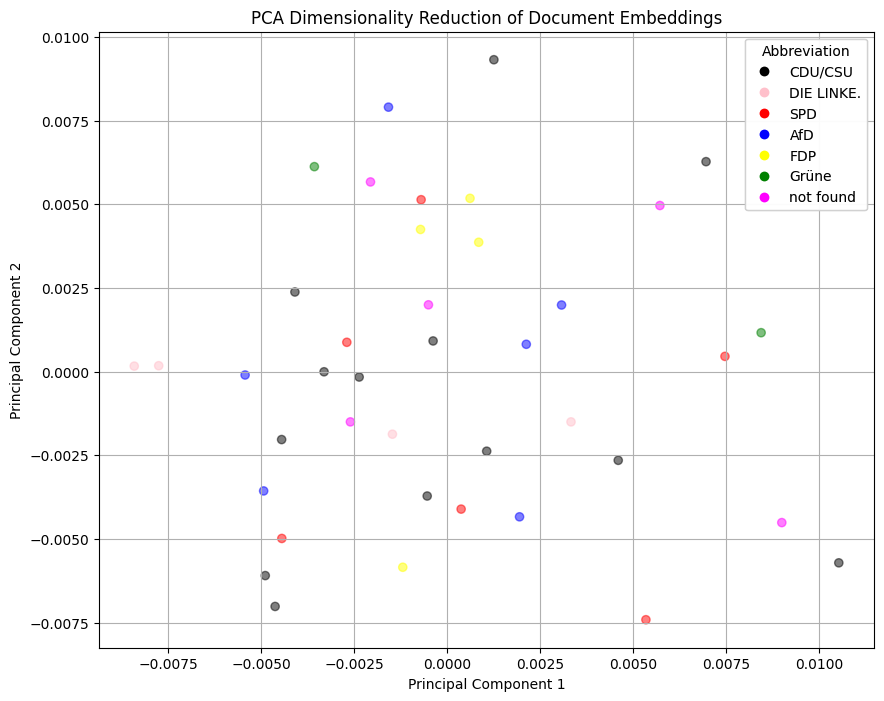

In [126]:
import matplotlib.pyplot as plt

# Define custom colors for each abbreviation
abbreviation_colors = {
    'CDU/CSU': 'black',
    'DIE LINKE.': 'pink',
    'SPD': 'red',
    'AfD':'blue',
    'FDP': 'yellow',
    'Grüne': 'green',
    'not found': 'magenta',
}

# Plot the embeddings with color coding by string categories and custom colors
plt.figure(figsize=(10, 8))
scatter = plt.scatter(document_embeddings[:, 0], document_embeddings[:, 1], c=filtered_df["abbreviation"].map(abbreviation_colors), alpha=0.5)

# Create custom legend
legend_elements = [plt.Line2D([0], [0], marker='o', color=color, label=abbreviation, linestyle='') for abbreviation, color in abbreviation_colors.items()]
legend1 = plt.legend(handles=legend_elements, title="Abbreviation", loc='upper right')

plt.title('PCA Dimensionality Reduction of Document Embeddings')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)

# Add legend to the plot
plt.gca().add_artist(legend1)

plt.show()


C:\Users\elias\AppData\Local\Temp\ipykernel_22784\2123715701.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_map = plt.cm.get_cmap('tab10', num_unique_values)  # You can choose any colormap here
C:\Users\elias\AppData\Local\Temp\ipykernel_22784\2123715701.py:16: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(document_embeddings[:, 0], document_embeddings[:, 1], c=colors, cmap=color_map)


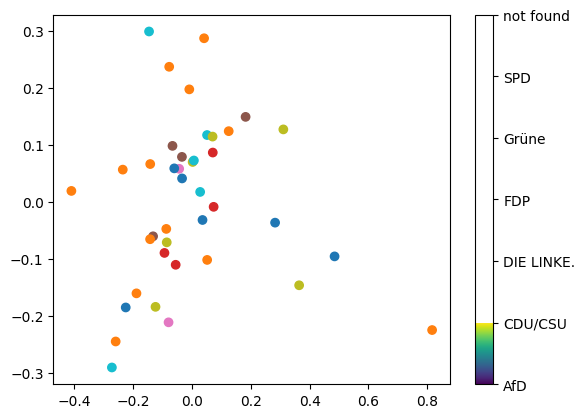

In [39]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# Define colors for each unique value in the encoding variable
unique_values = sorted(set(filtered_df["abbreviation"]))
num_unique_values = len(unique_values)
color_map = plt.cm.get_cmap('tab10', num_unique_values)  # You can choose any colormap here

# Create a colormap dictionary mapping values to colors
color_dict = {value: color_map(i) for i, value in enumerate(unique_values)}

# Map colors to encoding values
colors = [color_dict[value] for value in filtered_df["abbreviation"]]

# Plot the scatterplot
plt.scatter(document_embeddings[:, 0], document_embeddings[:, 1], c=colors, cmap=color_map)

# Add a color bar for reference
cbar = plt.colorbar()
cbar.set_ticks(range(num_unique_values))
cbar.set_ticklabels(unique_values)

plt.show()


In [ ]:
import gensim
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from gensim.models.phrases import Phrases, Phraser
from gensim import corpora
from collections import namedtuple
import logging

logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
assert gensim.models.doc2vec.FAST_VERSION > -1

class corpusIterator(object):

    def __init__(self, data, bigram=None, trigram=None):
        if bigram:
            self.bigram = bigram
        else:
            self.bigram = None
        if trigram:
            self.trigram = trigram
        else:
            self.trigram = None
        self.data = data

    def __iter__(self):
        self.speeches = namedtuple('speeches', 'words tags')
        with open(self.inpath, 'r') as f:
            for line in f:
                ls = line.split('\t')
                chamber = ls[5]
                if chamber==self.house:
                    text = ls[10].replace('\n','')
                    congress = str(ls[0])
                    party = ls[7]
                    partytag = party + '_' + congress
                    congresstag = 'CONGRESS_' + congress
                    tokens = text.split()
                    if self.bigram and self.trigram:
                        self.words = self.trigram[self.bigram[tokens]]
                    elif self.bigram and not self.trigram:
                        self.words = self.bigram[tokens]
                    else:
                        self.words = tokens
                    self.tags = [partytag, congresstag]
                    yield self.speeches(self.words, self.tags)

class phraseIterator(object):

    def __init__(self, inpath, house):
        self.inpath = inpath
        self.house = house

    def __iter__(self):
        with open(self.inpath, 'r') as f:
            for line in f:
                ls = line.split('\t')
                chamber = ls[5]
                if chamber==self.house:
                    text = ls[10].replace('\n','')
                    yield text.split()


print("Check")
#if __name__=='__main__':

    # Fill in the paths to desired location.
    # Corpus is expected to be in tab-separated format with column ordering specified in
    # reformat_congress.py, and clean text in column #10.

    #inpath = '.../congress'
    #savepath = '.../usa/'

    #phrases = Phrases(phraseIterator(inpath, house='H'))
    #bigram = Phraser(phrases)
    #tphrases = Phrases(bigram[phraseIterator(inpath, house='H')])
    #trigram = Phraser(tphrases)

    # To save phraser objects for future usage.
    # bigram.save('.../phraser_bigrams')
    # trigram.save('.../phraser_trigrams')

model0 = Doc2Vec(vector_size=200, window=20, min_count=50, workers=8, epochs=5)
model0.build_vocab(corpusIterator(documents))
    #model0.train(corpusIterator(inpath, house='H', bigram=bigram, trigram=trigram), total_examples=model0.corpus_count, epochs=model0.epochs)
    #model0.save(savepath + 'house')

2024-03-15 10:45:37,425 : INFO : Doc2Vec lifecycle event {'params': 'Doc2Vec<dm/m,d200,n5,w20,mc50,s0.001,t8>', 'datetime': '2024-03-15T10:45:37.425758', 'gensim': '4.3.2', 'python': '3.11.3 (tags/v3.11.3:f3909b8, Apr  4 2023, 23:49:59) [MSC v.1934 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19045-SP0', 'event': 'created'}


Check


NameError: name 'documents' is not defined